## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", None)

In [2]:
samsung_path = "../data/samsung.csv"
apple_path = "../data/apple.csv"

## Functions

In [3]:
# Function for making histogram 
def length_distribution(column, title, x_label, num_bins, color):        
    plt.figure(figsize=(10,8))
    plt.hist(column, bins = num_bins, color = color, edgecolor = "black")

    #Add chart labels
    plt.title(title, fontsize=13)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel("Number of Frequency", fontsize=12);

In [4]:
# Define the function for cleaning the text
def text_preprocess(text):
    
    # Convert sentences into lowercase
    text["description"] = text["description"].apply(lambda c: c.lower())
    
    # Remove special characters and numbers present in the text
    text["description"] = text["description"].apply(lambda c: c.replace("[^A-Za-z]",""))
    
    # Remove punctuations in the text
    #text['caption'] = text['caption'].apply(lambda c: c.replace("!()-[]{};:\,<=>./?@#$%^&*_~''", ''))
        
    # Remove extra spaces
    text["description"] = text["description"].apply(lambda c: c.replace("\s+"," "))
    
    # Remove single characters
    text["description"] = text["description"].apply(lambda c: " ".join([word for word in c.split() if len(word)>1]))
    
    # Remove stop words
    #text["description"] = text["description"].apply(lambda c: " ".join([word for word in c.split() if word not in stopwords.words("english")]))
    
    # Stemming words
    #ps = PorterStemmer()
    
    #text["description"] = text["description"].apply(lambda c: " ".join([ps.stem(word) for word in c.split()]))
        
    return text

In [5]:
# Function for instantiating CountVectorizer, fit and transform on corpus and finaly plot the most occurred words 
def vectorizing_df(column, ngram_range, dfname, color):
    X = column
    cvec = CountVectorizer(stop_words="english", ngram_range=ngram_range)
    cvec.fit(X)
    X = cvec.transform(X)

    # convert X to dataframe
    df_vec = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())
    print(f"Number of tokens after applying CountVectorizer on {dfname} Dataframe: {df_vec.shape[1]}")

    # plot most occured words
    df_vec.sum().sort_values(ascending=False).head(20).plot(kind="barh",
                            color = color, edgecolor = "black")
    plt.title(f"Most words in Posts of {dfname}", fontsize=12)
    plt.xlabel("Number of Words", fontsize=10)
    plt.ylabel("Words", fontsize=10);

## Exploatory Data Analysis (EDA) and Preprocessing

### Samsung Galaxy Watch
In the following cells I'll do some exploring and cleaning in samsung dataframe and will make a new dataframe as a galaxy watch which only has usefull columns for EDA

In [6]:
# load data
df_samsung = pd.read_csv(samsung_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df_samsung.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df_samsung.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df_samsung.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df_samsung.shape[1]}")

Sample Data :     subreddit  \
0  GalaxyWatch   
1  GalaxyWatch   
2  GalaxyWatch   
3  GalaxyWatch   
4  GalaxyWatch   

                                                                                                                                                                                                                                                                                                                                                                                                                                 selftext  \
0                                                                                                          Hey! Join me this month for the fitness challenge.  This is a big month for me and I am going to need support and motivation in the following months. I'd appreciate it!\n\nJoin the Lavender, May challenge! Get special badges and get fit with a community in Samsung Health Together https://shealth.samsung.com/s/pyPFbND   
1                   

In [7]:
# check the missing values in selftext with theire equivalents in title
print(f"Number of missing values in title column: {df_samsung['title'].isna().sum()}")
print(f"Number of missing values in selftext column: {df_samsung['selftext'].isna().sum()}")

df_samsung.loc[df_samsung["selftext"].isna(), ["title", "selftext"]]

Number of missing values in title column: 0
Number of missing values in selftext column: 1141


,title,selftext
5,If i download around 2GB of spotify music in my watch 4 classic will it effect the performance of my watch?,NaN
10,Awful Battery,NaN
20,"I have a new watch 5. I can make calls on it with no problem (it's LTE); but I can't receive calls on it. When I answer on my watch, it then directs me to my phone. Also, we got them through a BOGO deal and my daughter's answers calls fine. Help please",NaN
23,Up to 80% off from Apr 26 to May 3 for the CELEST 3020 Digital Watch on the Google Play Store!,NaN
25,Pretty good battery life this weekend on my GW4 Classic,NaN
...,...,...
3489,"In the always-on mode of the Galaxy Watch active R500, the clock face is not the right size. Please fix this problem in the next updates.",NaN
3490,"Calls aren't showing 1/5 times in GW4, even when connected. Anyone else or any solutions?",NaN
3491,Aye yo wtf !?,NaN
3492,GMT master ii white gold GW4 40mm,NaN


In [8]:
# cite for using map str: https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/#:~:text=Combine%20Two%20Columns%20Using%20%2B%20Operator,does%20addition%20instead%20of%20concatenation.
# Fill missing values () in selftext with space
df_samsung["selftext"] = df_samsung["selftext"].fillna("")
df_samsung["selftext"] = df_samsung["selftext"].replace("[removed]", "")
df_samsung["description"] = (df_samsung["selftext"].map(str) + " " + df_samsung["title"]).str.strip()

# check the description column
df_samsung.loc[:,["title", "selftext", "description"]]

,title,selftext,description
0,May Fitness Challenge,"Hey! Join me this month for the fitness challenge. This is a big month for me and I am going to need support and motivation in the following months. I'd appreciate it!\n\nJoin the Lavender, May challenge! Get special badges and get fit with a community in Samsung Health Together https://shealth.samsung.com/s/pyPFbND","Hey! Join me this month for the fitness challenge. This is a big month for me and I am going to need support and motivation in the following months. I'd appreciate it!\n\nJoin the Lavender, May challenge! Get special badges and get fit with a community in Samsung Health Together https://shealth.samsung.com/s/pyPFbND May Fitness Challenge"
1,What's this about?,I noticed the DISPLAY watch is better then the actual watch you buy... (Yes I am on the latest software),I noticed the DISPLAY watch is better then the actual watch you buy... (Yes I am on the latest software) What's this about?
2,Option to have notifications on watch even when off your wrist?,I got a tattoo on my wrist and my watch thinks it's not on my body so I miss notifications. \nAny setting to have us receive notifications even if the watch is charging or on our dresser? Or in my case still on my body but not detecting it?,I got a tattoo on my wrist and my watch thinks it's not on my body so I miss notifications. \nAny setting to have us receive notifications even if the watch is charging or on our dresser? Or in my case still on my body but not detecting it? Option to have notifications on watch even when off your wrist?
3,Not receiving notifications or Watch,"So when I open my galaxy wearables app, go to watch settings and click on notifications, the entire app crashes.\n\nI tried an alternate route by going to the watches settings app, then to notifications, and when I click app notifications, it says continue on phone and it does open in the phone but it says no apps. \n\nI tried rebooting the watch and the phone but nothing seems to work, help would be appreciated a lot!","So when I open my galaxy wearables app, go to watch settings and click on notifications, the entire app crashes.\n\nI tried an alternate route by going to the watches settings app, then to notifications, and when I click app notifications, it says continue on phone and it does open in the phone but it says no apps. \n\nI tried rebooting the watch and the phone but nothing seems to work, help would be appreciated a lot! Not receiving notifications or Watch"
4,GW5 and specific WiFi SSID,"I have a number of SSID's in my home for different purposes. For some reason, my watch keeps connecting to an isolated VLAN that is designed solely for the XBOX. Other than shutting the WiFi off, how do I ensure the watch does not try to connect to this particular SSID?","I have a number of SSID's in my home for different purposes. For some reason, my watch keeps connecting to an isolated VLAN that is designed solely for the XBOX. Other than shutting the WiFi off, how do I ensure the watch does not try to connect to this particular SSID? GW5 and specific WiFi SSID"
...,...,...,...
3493,Automatically given steps,"I was at the gym tonight and noticed my watch lowered my total to 1100 steps before shooting back up to my total. It is now past midnight and should be at zero, but suddenly my watch has begun today at 1100 steps. Has anyone experienced this type of error before and remedied it? I performed a factory reset, nothing changed, so I restored my backup on to the watch.","I was at the gym tonight and noticed my watch lowered my total to 1100 steps before shooting back up to my total. It is now past midnight and should be at zero, but suddenly my watch has begun today at 1100 steps. Has anyone experienced this type of error before and remedied it? I performed a factory reset, nothing changed, so I restored my backup on to the watch. Automatically given steps"
3494,Why the FUCK did Google Assistant force my watch to reset?,"Why is Google so shi

In [9]:
df_samsung["description"][133]

'GW5 extremely low battery life'

In [10]:
# make a new dataframe for EDA
df_galaxywatch = df_samsung.loc[:,["author", "description", "subreddit"]]
df_galaxywatch.head()

,author,description,subreddit
0,SunflowerNBarbedWire,"Hey! Join me this month for the fitness challenge. This is a big month for me and I am going to need support and motivation in the following months. I'd appreciate it!\n\nJoin the Lavender, May challenge! Get special badges and get fit with a community in Samsung Health Together https://shealth.samsung.com/s/pyPFbND May Fitness Challenge",GalaxyWatch
1,TypicalZedF,I noticed the DISPLAY watch is better then the actual watch you buy... (Yes I am on the latest software) What's this about?,GalaxyWatch
2,CCJ22,I got a tattoo on my wrist and my watch thinks it's not on my body so I miss notifications. \nAny setting to have us receive notifications even if the watch is charging or on our dresser? Or in my case still on my body but not detecting it? Option to have notifications on watch even when off your wrist?,GalaxyWatch
3,No_Pudding4739,"So when I open my galaxy wearables app, go to watch settings and click on notifications, the entire app crashes.\n\nI tried an alternate route by going to the watches settings app, then to notifications, and when I click app notifications, it says continue on phone and it does open in the phone but it says no apps. \n\nI tried rebooting the watch and the phone but nothing seems to work, help would be appreciated a lot! Not receiving notifications or Watch",GalaxyWatch
4,PhobicCarrot,"I have a number of SSID's in my home for different purposes. For some reason, my watch keeps connecting to an isolated VLAN that is designed solely for the XBOX. Other than shutting the WiFi off, how do I ensure the watch does not try to connect to this particular SSID? GW5 and specific WiFi SSID",GalaxyWatch


In [11]:
# export and save galaxywatch dataframe
#df_galaxywatch.to_csv('../data/galaxy_watch.csv')

In [12]:
# number of unique authors
print(f"Number of unique authors: {df_galaxywatch['author'].nunique()}")

# filtering description and counting them by their authors
df_galaxywatch.groupby("author")["description"].agg(["count"]).sort_values("count", ascending = False)

Number of unique authors: 2457


,count
author,
DADAMWF,23
Own_Statement_8788,18
No-Impress3806,14
rusahitam,14
MyWatchFace,14
...,...
Nightwing55,1
NightFuryX0,1
NightAshamed,1


In [13]:
# Drop the duplicate authors
df_galaxywatch.drop_duplicates(subset="author", keep="first", inplace=True)
print(f"The size of the galaxy watch subreddit dataframe after removing duplicate authors: {df_galaxywatch.shape[0]}")

The size of the galaxy watch subreddit dataframe after removing duplicate authors: 2457


In [14]:
# Drop the duplicate descriptions
df_galaxywatch.drop_duplicates(subset="description", keep="first", inplace=True)
print(f"The size of the galaxy watch subreddit dataframe after removing duplicate descriptions: {df_galaxywatch.shape[0]}")

The size of the galaxy watch subreddit dataframe after removing duplicate descriptions: 2455


In [15]:
# Apply the text preprocessing (cleaning) function on galaxy watch descriptions
text_preprocess(df_galaxywatch)

,author,description,subreddit
0,SunflowerNBarbedWire,"hey! join me this month for the fitness challenge. this is big month for me and am going to need support and motivation in the following months. i'd appreciate it! join the lavender, may challenge! get special badges and get fit with community in samsung health together https://shealth.samsung.com/s/pypfbnd may fitness challenge",GalaxyWatch
1,TypicalZedF,noticed the display watch is better then the actual watch you buy... (yes am on the latest software) what's this about?,GalaxyWatch
2,CCJ22,got tattoo on my wrist and my watch thinks it's not on my body so miss notifications. any setting to have us receive notifications even if the watch is charging or on our dresser? or in my case still on my body but not detecting it? option to have notifications on watch even when off your wrist?,GalaxyWatch
3,No_Pudding4739,"so when open my galaxy wearables app, go to watch settings and click on notifications, the entire app crashes. tried an alternate route by going to the watches settings app, then to notifications, and when click app notifications, it says continue on phone and it does open in the phone but it says no apps. tried rebooting the watch and the phone but nothing seems to work, help would be appreciated lot! not receiving notifications or watch",GalaxyWatch
4,PhobicCarrot,"have number of ssid's in my home for different purposes. for some reason, my watch keeps connecting to an isolated vlan that is designed solely for the xbox. other than shutting the wifi off, how do ensure the watch does not try to connect to this particular ssid? gw5 and specific wifi ssid",GalaxyWatch
...,...,...,...
3493,ass_acoustics,"was at the gym tonight and noticed my watch lowered my total to 1100 steps before shooting back up to my total. it is now past midnight and should be at zero, but suddenly my watch has begun today at 1100 steps. has anyone experienced this type of error before and remedied it? performed factory reset, nothing changed, so restored my backup on to the watch. automatically given steps",GalaxyWatch
3494,Valiantay,"why is google so shit? simply enabling the assistant on my watch forced it to disconnect and now it requires complete reset. this is why people switch to apple, bullshit like this. why the fuck did google assistant force my watch to reset?",GalaxyWatch
3495,sleemldj,how can get nike run club app to work on my watch pro please? nike run club,GalaxyWatch
3496,elementfan94,looking for omega speedmaster moonphase in black color. can only find it in blue. any links to it? if not i'm happy with dms too. looking for omega speedmaster moonphase watchface,GalaxyWatch


In [16]:
df_galaxywatch["description"][3496]

"looking for omega speedmaster moonphase in black color. can only find it in blue. any links to it? if not i'm happy with dms too. looking for omega speedmaster moonphase watchface"

In [17]:
# Make a new column to show word count of description
df_galaxywatch["des_word_count"] = df_galaxywatch["description"].str.split().str.len()

# Five longest descriptions
df_galaxywatch.sort_values(by = "des_word_count", ascending=False).head()

author  \
3335      baiduelectronics   
1606        sonicintrusion   
2276  Alcoholfreeliketwice   
2348              Gadgety1   
818               jayfiled   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [18]:
# Five shortest description
df_galaxywatch.sort_values(by = "des_word_count", ascending=False).tail()

,author,description,subreddit,des_word_count
935,teachertmh,did it,GalaxyWatch,2
605,Appropriate_Eye5063,looking nice,GalaxyWatch,2
1373,Tonnicle02,glaz band,GalaxyWatch,2
2650,CheapScientist5603,malware,GalaxyWatch,1
2039,Independent-Elk9983,opinions?,GalaxyWatch,1


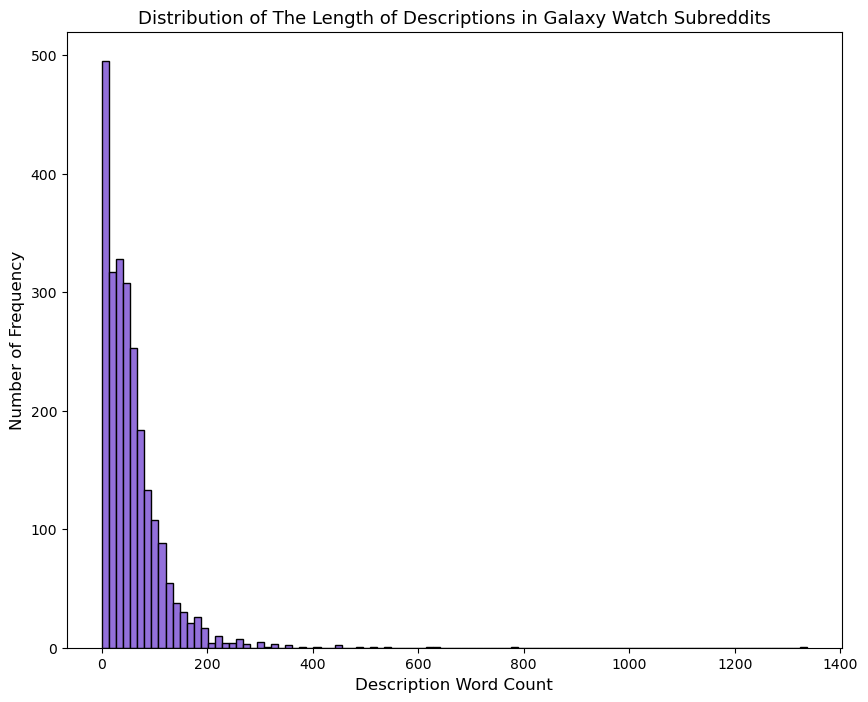

In [19]:
# distribution of description length based on word count
length_distribution(column=df_galaxywatch["des_word_count"],
                    title="Distribution of The Length of Descriptions in Galaxy Watch Subreddits",
                    x_label="Description Word Count",
                    num_bins=100, color="mediumpurple")

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens after applying CountVectorizer on Galaxy Watch Dataframe: 123648


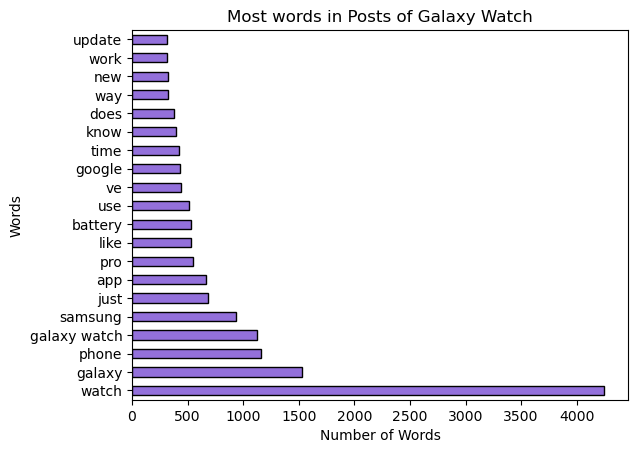

In [20]:
vectorizing_df(column=df_galaxywatch["description"],
               ngram_range=(1,3), dfname="Galaxy Watch", color="mediumpurple")

### Apple Watch
In the following cells I'll do some exploring and cleaning in apple dataframe and will make a new dataframe as a apple watch which only has usefull columns for EDA

In [21]:
# Load data
df_apple = pd.read_csv(apple_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df_apple.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df_apple.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df_apple.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df_apple.shape[1]}")

Sample Data :    subreddit  \
0  AppleWatch   
1  AppleWatch   
2  AppleWatch   
3  AppleWatch   
4  AppleWatch   

                                                                                                                                                                                                                                                                                                      selftext  \
0                                                                                                                                           \nyes, it's an LTE watch with data turned on, no phone with my. streaming music to my airpods - but all the music is downloaded on my watch. this is infuriating..   
1                                                                                                                                                                                                                                                                               

In [22]:
# Check the missing values in selftext with theire equivalents in title
print(f"Number of missing values in title column: {df_apple['title'].isna().sum()}")
print(f"Number of missing values in selftext column: {df_apple['selftext'].isna().sum()}")

df_apple.loc[df_apple["selftext"].isna(), ["title", "selftext"]]

Number of missing values in title column: 0
Number of missing values in selftext column: 1142


,title,selftext
1,How accurate is the active/total calorie tracking on the AW?,NaN
3,Pls tell me i‘m not the only one who has such a fast heartrate doing nothing,NaN
4,Deleted Apps in Watch App on iPhone with weird names - is a way to remove them ?,NaN
5,What is this complication?,NaN
7,Series 8 midnight with oem link bracelet,NaN
...,...,...
3483,is 92% battery health good for a second hand apple watch series 4 that i purchased about a year ago?,NaN
3488,"Now I can use the watch with peace of mind of not hitting the walls! OtterBox Exo Edge, great case.",NaN
3490,Purchased the AW S8 in starlight with the chalk pink band! I love it! Debating on returning for the 45mm…,NaN
3496,"First time testing clockology, fun app",NaN


In [23]:
# Cite for using map str: https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/#:~:text=Combine%20Two%20Columns%20Using%20%2B%20Operator,does%20addition%20instead%20of%20concatenation.
# Fill missing values () in selftext with space
df_apple["selftext"] = df_apple["selftext"].fillna("")
df_apple["selftext"] = df_apple["selftext"].replace("[removed]", "")
df_apple["description"] = (df_apple["selftext"].map(str) + " " + df_apple["title"]).str.strip()

# check the description column
df_apple.loc[:,["title", "selftext", "description"]]

,title,selftext,description
0,why is my S7 going from almost fully charged to 5% and turning itself off during a 1 hour run?,"\nyes, it's an LTE watch with data turned on, no phone with my. streaming music to my airpods - but all the music is downloaded on my watch. this is infuriating..","yes, it's an LTE watch with data turned on, no phone with my. streaming music to my airpods - but all the music is downloaded on my watch. this is infuriating.. why is my S7 going from almost fully charged to 5% and turning itself off during a 1 hour run?"
1,How accurate is the active/total calorie tracking on the AW?,,How accurate is the active/total calorie tracking on the AW?
2,Lost watch when blackout drunk,"Fell very hard blackout drunk and lost watch. Three days later I got up from bed and found it, thanks to Find My Watch!Couple scratches here and there but I’m just too grateful for finding it. \n\nJust saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!!","Fell very hard blackout drunk and lost watch. Three days later I got up from bed and found it, thanks to Find My Watch!Couple scratches here and there but I’m just too grateful for finding it. \n\nJust saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!! Lost watch when blackout drunk"
3,Pls tell me i‘m not the only one who has such a fast heartrate doing nothing,,Pls tell me i‘m not the only one who has such a fast heartrate doing nothing
4,Deleted Apps in Watch App on iPhone with weird names - is a way to remove them ?,,Deleted Apps in Watch App on iPhone with weird names - is a way to remove them ?
...,...,...,...
3494,LPT: Not sure your band is titanium? Use a magnet.,"Stainless steel is magnetic, titanium is not. \n\nSellers are scamming with &gt;$60 stainless steel bands sold as titanium. This helped me get a refund from Bezeli.","Stainless steel is magnetic, titanium is not. \n\nSellers are scamming with &gt;$60 stainless steel bands sold as titanium. This helped me get a refund from Bezeli. LPT: Not sure your band is titanium? Use a magnet."
3495,Trying to find specific watch face (pic included),Feel like this is a really dumb question but for the life of me I can't figure it out.\n\nI got a new Apple Watch Series 8 and I specifically wanted to have this look:\n\nhttps://i.imgur.com/fUspHs2.png\n\n...but I can't find what face that is or how to modify an existing face.\n\nAm I missing something?\n\nThanks!,Feel like this is a really dumb question but for the life of me I can't figure it out.\n\nI got a new Apple Watch Series 8 and I specifically wanted to have this look:\n\nhttps://i.imgur.com/fUspHs2.png\n\n...but I can't find what face that is or how to modify an existing face.\n\nAm I missing something?\n\nThanks! Trying to find specific watch face (pic included)
3496,"First time testing clockology, fun app",,"First time testing clockology, fun app"
3497,Sleep paralysis and AW,,Sleep paralysis and AW


In [24]:
df_apple["description"][133]

"I can't seem to find the option. Can you erase your iPhone or iPad or Macbook from your Apple Watch?"

In [25]:
# Make a new dataframe for EDA
df_applewatch = df_apple.loc[:,["author", "description", "subreddit"]]
df_applewatch.head()

,author,description,subreddit
0,TuaAnon,"yes, it's an LTE watch with data turned on, no phone with my. streaming music to my airpods - but all the music is downloaded on my watch. this is infuriating.. why is my S7 going from almost fully charged to 5% and turning itself off during a 1 hour run?",AppleWatch
1,DemandScary1934,How accurate is the active/total calorie tracking on the AW?,AppleWatch
2,Vinumite,"Fell very hard blackout drunk and lost watch. Three days later I got up from bed and found it, thanks to Find My Watch!Couple scratches here and there but I’m just too grateful for finding it. \n\nJust saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!! Lost watch when blackout drunk",AppleWatch
3,Damarou,Pls tell me i‘m not the only one who has such a fast heartrate doing nothing,AppleWatch
4,ThorNike13,Deleted Apps in Watch App on iPhone with weird names - is a way to remove them ?,AppleWatch


In [26]:
# Export and save applewatch dataframe
#df_applewatch.to_csv('../data/apple_watch.csv')

In [27]:
# Number of unique authors
print(f"Number of unique authors: {df_applewatch['author'].nunique()}")

# Filtering description and counting them by their authors
df_applewatch.groupby("author")["description"].agg(["count"]).sort_values("count", ascending = False)

Number of unique authors: 2817


,count
author,
JJJJounol,10
Captain-DK,9
RunningM8,9
p_r96,8
MasBoy3000,8
...,...
Omhire,1
OneFutureOfMany,1
OnePunchDoge,1


In [28]:
# Drop the duplicate authors
df_applewatch.drop_duplicates(subset="author", keep="first", inplace=True)
print(f"The size of the applewatch subreddit dataframe after removing duplicate authors: {df_applewatch.shape[0]}")

The size of the applewatch subreddit dataframe after removing duplicate authors: 2817


In [29]:
# Drop the duplicate descriptions
df_applewatch.drop_duplicates(subset="description", keep="first", inplace=True)
print(f"The size of the applewatch subreddit dataframe after removing duplicate descriptions: {df_applewatch.shape[0]}")

The size of the applewatch subreddit dataframe after removing duplicate descriptions: 2815


In [30]:
# Apply the text preprocessing (cleaning) function on applewatch descriptions
text_preprocess(df_applewatch)

,author,description,subreddit
0,TuaAnon,"yes, it's an lte watch with data turned on, no phone with my. streaming music to my airpods but all the music is downloaded on my watch. this is infuriating.. why is my s7 going from almost fully charged to 5% and turning itself off during hour run?",AppleWatch
1,DemandScary1934,how accurate is the active/total calorie tracking on the aw?,AppleWatch
2,Vinumite,"fell very hard blackout drunk and lost watch. three days later got up from bed and found it, thanks to find my watch!couple scratches here and there but i’m just too grateful for finding it. just saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!! lost watch when blackout drunk",AppleWatch
3,Damarou,pls tell me i‘m not the only one who has such fast heartrate doing nothing,AppleWatch
4,ThorNike13,deleted apps in watch app on iphone with weird names is way to remove them,AppleWatch
...,...,...,...
3493,actuarialstudent_88,"i’ve been wearing my apple watch series for over month. this morning saw that from around to am while was sleeping, my heart rate was recorded of 130bpm during that hour while it was 60-70 before and after that. however didn’t see any high heart rate notification although set it for any hr above 120. also the watch didn’t track my sleep last night so couldn’t check what stage of sleep was in. i’m wondering if anyone went through this before and is this just glitch or an issue? thanks in advance! high heart rate recorded during sleep",AppleWatch
3494,Metatropico,"stainless steel is magnetic, titanium is not. sellers are scamming with &gt;$60 stainless steel bands sold as titanium. this helped me get refund from bezeli. lpt: not sure your band is titanium? use magnet.",AppleWatch
3495,HarpuaFSB,feel like this is really dumb question but for the life of me can't figure it out. got new apple watch series and specifically wanted to have this look: https://i.imgur.com/fusphs2.png ...but can't find what face that is or how to modify an existing face. am missing something? thanks! trying to find specific watch face (pic included),AppleWatch
3497,Osran94,sleep paralysis and aw,AppleWatch


In [31]:
# Make a new column to show word count of description
df_applewatch["des_word_count"] = df_applewatch["description"].str.split().str.len()

# Five longest descriptions
df_applewatch.sort_values(by = "des_word_count", ascending=False).head()

author  \
591             sathomasga   
320   AccomplishedWindow49   
257                obyboby   
722            onetonenote   
2998             PolarSuns   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [32]:
# Five shortest description
df_applewatch.sort_values(by = "des_word_count", ascending=False).tail()

,author,description,subreddit,des_word_count
2818,-Guido-K,proud,AppleWatch,1
2863,chrizm32,buh-bam!,AppleWatch,1
1963,youtubeguru0,https://music.apple.com/us/album/destination-beautiful-single/1678004647,AppleWatch,1
416,LividFlow9228,ssssssssssssssssssssssssssssssssssssssssssssssss,AppleWatch,1
316,Snoo_79802,ok,AppleWatch,1


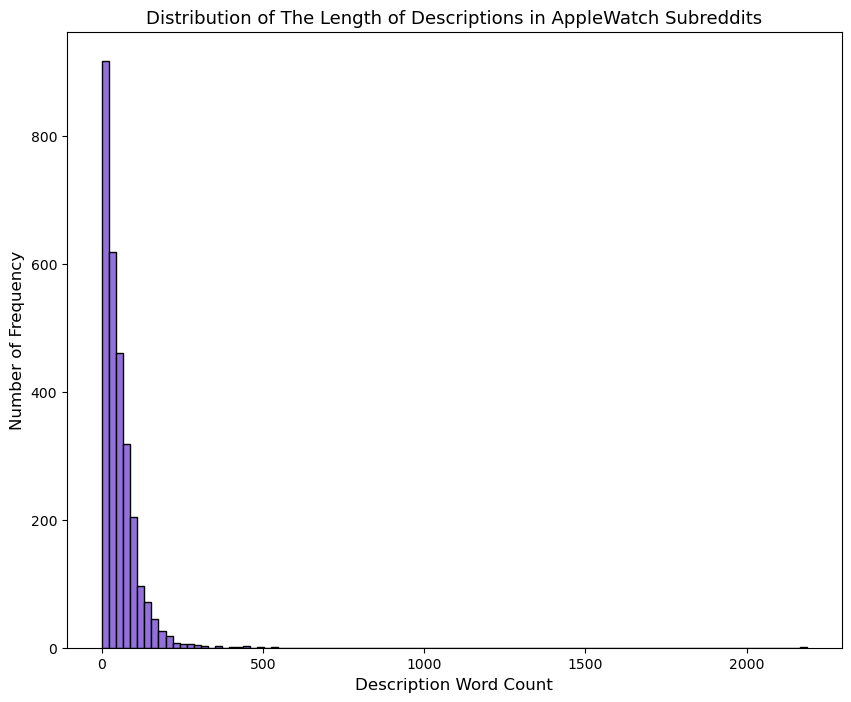

In [33]:
# Distribution of description length based on word count
length_distribution(column=df_applewatch["des_word_count"],
                    title="Distribution of The Length of Descriptions in AppleWatch Subreddits",
                    x_label="Description Word Count",
                    num_bins=100, color="mediumpurple")

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens after applying CountVectorizer on AppleWatch Dataframe: 130301


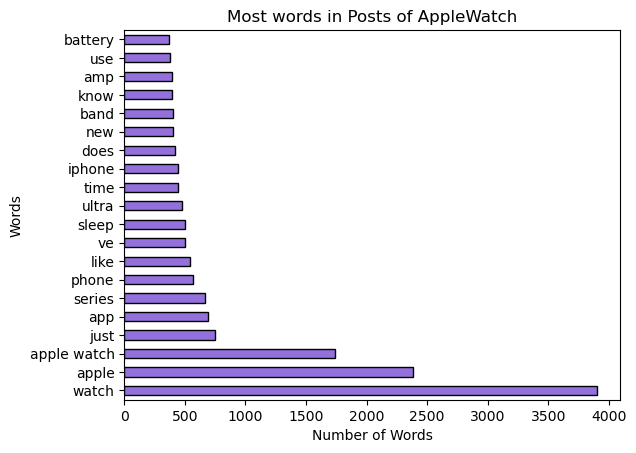

In [34]:
vectorizing_df(column=df_applewatch["description"],
               ngram_range=(1,3), dfname="AppleWatch", color="mediumpurple")

## Final Dataset

In [35]:
# Combine Applewatch and Galaxy Watch datasets
df = pd.concat([df_applewatch, df_galaxywatch], axis=0)

# Get the size and ratio of subreddits in final dataset
print(f"Size of the final dataset: {df.shape[0]}\n")
print(" Ratio of Subreddits ".center(38, "="))
print(df["subreddit"].value_counts(normalize=True))
df.head()

Size of the final dataset: 5270

======== Ratio of Subreddits =========
AppleWatch     0.534156
GalaxyWatch    0.465844
Name: subreddit, dtype: float64


,author,description,subreddit,des_word_count
0,TuaAnon,"yes, it's an lte watch with data turned on, no phone with my. streaming music to my airpods but all the music is downloaded on my watch. this is infuriating.. why is my s7 going from almost fully charged to 5% and turning itself off during hour run?",AppleWatch,48
1,DemandScary1934,how accurate is the active/total calorie tracking on the aw?,AppleWatch,10
2,Vinumite,"fell very hard blackout drunk and lost watch. three days later got up from bed and found it, thanks to find my watch!couple scratches here and there but i’m just too grateful for finding it. just saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!! lost watch when blackout drunk",AppleWatch,59
3,Damarou,pls tell me i‘m not the only one who has such fast heartrate doing nothing,AppleWatch,15
4,ThorNike13,deleted apps in watch app on iphone with weird names is way to remove them,AppleWatch,15


## Save the Final Dataset

In [36]:
# Save and export the final dataset
df.to_csv("../data/final_dataset.csv")

## Sentimental Analysis
Sentiment analysis is a natural language processing (NLP) technique that aims to determine the sentiment or emotional tone expressed in a piece of text. It involves analyzing the subjective information present in the text and classifying it as positive, negative, or neutral.

VADER is a popular and widely used lexicon-based sentiment analysis tool. It was specifically developed for analyzing sentiments in social media text. VADER combines a sentiment lexicon with a set of grammatical rules to accurately measure sentiment intensity. It can handle informal language, emoticons, and even negations, which are common in social media data.

What makes VADER particularly useful is its ability to handle contextual information and nuances in sentiment expression. It not only considers individual words but also takes into account the effects of punctuation, capitalization, and conjunctions. This makes VADER effective in capturing the sentiment in short and informal texts, such as social media posts or customer reviews.

In our project, sentiment analysis using VADER can help us gauge the sentiment of the posts made by users. By analyzing the sentiment, we can understand the overall opinion or emotional tone of the discussions within the subreddit. This information can be valuable for predicting trends, identifying user satisfaction or dissatisfaction, or understanding user preferences regarding Apple Watch and Galaxy Watch products.

The compound score, generated by the VADER sentiment analyzer, represents the overall sentiment polarity of a given text. It takes into account the individual sentiment scores of the text's words and combines them to provide an overall sentiment score.

The compound score ranges between -1 and 1, where:

- Scores above 0 indicate a positive sentiment.
- Scores below 0 indicate a negative sentiment.
- Scores around 0 indicate a neutral sentiment.

The magnitude of the compound score represents the intensity of the sentiment. The closer the score is to -1 or 1, the stronger the sentiment expressed in the text.

In [37]:
# Make a copy of original final dataset
df_sentiment = df.copy()

# Instantiat the VADER
sa = SentimentIntensityAnalyzer()

# Add two columns for sentiment polarity scores and category
corpus = df_sentiment["description"]
sentiment_scores = [sa.polarity_scores(document)["compound"] for document in corpus]
sentiment_category = ["positive" if score > 0
                                     else "negative" if score < 0
                                     else "neutral"
                                     for score in sentiment_scores]
df_sentiment["sentiment_scores"] = sentiment_scores
df_sentiment["sentiment_category"] = sentiment_category
df_sentiment.head()

,author,description,subreddit,des_word_count,sentiment_scores,sentiment_category
0,TuaAnon,"yes, it's an lte watch with data turned on, no phone with my. streaming music to my airpods but all the music is downloaded on my watch. this is infuriating.. why is my s7 going from almost fully charged to 5% and turning itself off during hour run?",AppleWatch,48,-0.2434,negative
1,DemandScary1934,how accurate is the active/total calorie tracking on the aw?,AppleWatch,10,0.0000,neutral
2,Vinumite,"fell very hard blackout drunk and lost watch. three days later got up from bed and found it, thanks to find my watch!couple scratches here and there but i’m just too grateful for finding it. just saying, your watch can drop even from your wrist if you are way too drunk, be careful everyone!!! lost watch when blackout drunk",AppleWatch,59,-0.8670,negative
3,Damarou,pls tell me i‘m not the only one who has such fast heartrate doing nothing,AppleWatch,15,0.0772,positive
4,ThorNike13,deleted apps in watch app on iphone with weird names is way to remove them,AppleWatch,15,-0.1779,negative


In [38]:
# Describe the setiment scores by subreddits
df_sentiment.groupby("subreddit")["sentiment_scores"].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
AppleWatch,2815.0,0.207456,0.511688,-0.9900,0.00000,0.2023,0.66960,0.9998
GalaxyWatch,2455.0,0.186882,0.513903,-0.9882,-0.09395,0.1299,0.64065,0.9994


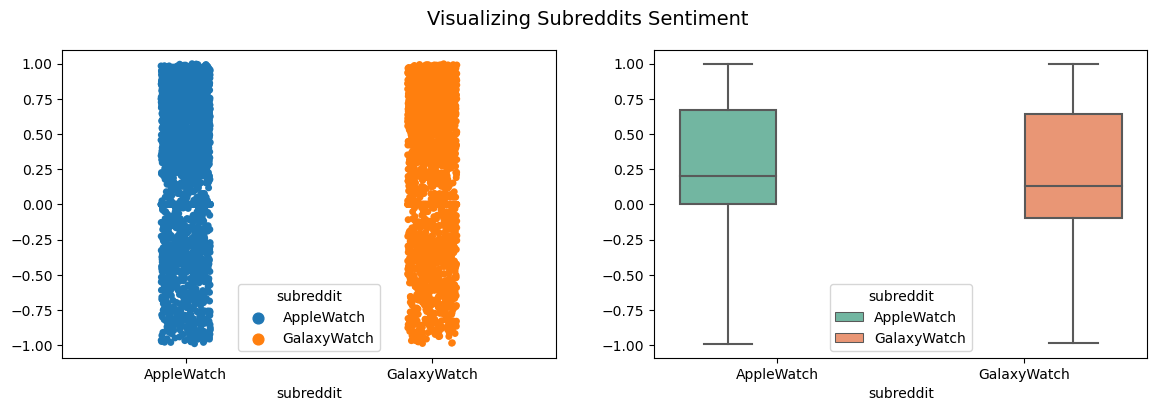

In [39]:
# Plot the spread of sentiment polarity
# Cite: Got below codes form https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.htm
# Cite: ldipanjanS/nlp_strategy_26.py
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x=df_sentiment["subreddit"], y=sentiment_scores, 
                   hue=df_sentiment["subreddit"], data=df_sentiment, ax=ax1)
bp = sns.boxplot(x=df_sentiment["subreddit"], y=sentiment_scores, 
                 hue=df_sentiment["subreddit"], data=df_sentiment, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing Subreddits Sentiment', fontsize=14)

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


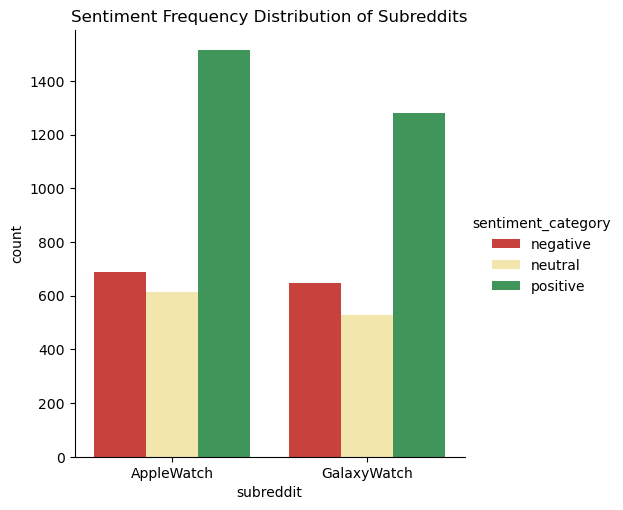

In [40]:
# Plot the frequency of sentiments
# Cite: Got below codes form https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.htm
# Cite: ldipanjanS/nlp_strategy_26.py
# Cite: Got the colors from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3
fc = sns.factorplot(x="subreddit", hue="sentiment_category", 
                    data=df_sentiment, kind="count", 
                    palette={"negative": "#de2d26", 
                             "positive": "#31a354", 
                             "neutral": "#ffeda0"})
plt.title("Sentiment Frequency Distribution of Subreddits");

In [41]:
# Check the most positive and negative posts in AppleWatch subreddit
apple_pos = (df_sentiment["subreddit"]=="AppleWatch") & (df_sentiment["sentiment_scores"] == 0.9998)
apple_neg = (df_sentiment["subreddit"]=="AppleWatch") & (df_sentiment["sentiment_scores"] == -0.9900)

print(" Most Negative Post in AppleWatch Subreddit ".center(70, "="))
print()
print(df_sentiment.loc[apple_neg, "description"])
print()
print(" Most Negative Post in AppleWatch Subreddit ".center(70, "="))
print()
print(df_sentiment.loc[apple_pos, "description"])

============= Most Negative Post in AppleWatch Subreddit =============

1768    pairing new apple watch is something fucking dread every single time. bought new watch week ago, and didn’t open the box until today because knew i’d need solid two hours just to get the damn thing working. don’t get me started on the fact that if the watch has its own number… it just doesn’t work. have to call the cell phone company every single time. there was also prompt that told me needed to “unpair” my watch and repair it to get the cellular connection to work. guess what that did? put me through the entire fucking setup process again. love apple products. but fucking hell, this is the worst god damn apple experience can imagine. fuckkkkk holy fucking shit, why in the fuck is it such pain in the ass to pair new apple watch with my phone every single time?
Name: description, dtype: object

============= Most Negative Post in AppleWatch Subreddit =============

591    disclaimer: want to be very clear f

In [42]:
# Check the most positive and negative posts in Galaxy Watch subreddit
galaxy_pos = (df_sentiment["subreddit"]=="GalaxyWatch") & (df_sentiment["sentiment_scores"] == 0.9994)
galaxy_neg = (df_sentiment["subreddit"]=="GalaxyWatch") & (df_sentiment["sentiment_scores"] == -0.9882)

print(" Most Negative Post in Galaxy Watch Subreddit ".center(70, "="))
print()
print(df_sentiment.loc[galaxy_neg, "description"])
print()
print(" Most Negative Post in Galaxy Watch Subreddit ".center(70, "="))
print()
print(df_sentiment.loc[galaxy_pos, "description"])

============ Most Negative Post in Galaxy Watch Subreddit ============

2961    i've had my galaxy watch5 44mm for little over month now. the reviews on reddit and elsewhere seemed to be mostly positive but i'm blown away by the poor performance almost across the board. fitness/sleep/health tracking, responsiveness and battery life are all substantially worse than expected. \- battery life is well under 24h from day one unless most features are disabled, including things i'd consider "base functionality" like continuous heartrate monitoring. \- touch screen has noticeable latency from day one, especially when trying to cycle between screens. the face completely freezes for second or so if try to cycle through them quickly. \- sleep tracking quality is very poor. sleep is also often arbitrarily separated into many smaller "naps", each with poor sleep scores, that can't be combined, making the metrics useless (afaik at least, the edit feature doesn't let me do anything in my samsung heal

### A few Notes to add for Sentimental Analysis
Cons of stemming before sentiment analysis:

- Loss of word meaning: Stemming algorithms reduce words to their base or root form, which can result in the loss of specific nuances and meaning. In some cases, this loss of information can impact the accuracy of sentiment analysis. For example, the word "not" can completely change the sentiment of a sentence, but stemming might remove it, leading to incorrect sentiment classification.
- VADER's built-in mechanisms: The VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool is specifically designed to handle social media text, which often contains informal language, slang, and emoticons. VADER incorporates lexicons and rules that account for these nuances. Stemming the text beforehand may interfere with VADER's ability to correctly interpret sentiment due to the changes made to the words.

Considering these factors, it's generally recommended to avoid stemming the text before using VADER for sentiment analysis. VADER is designed to handle raw, unprocessed text, including the specific variations of words, to capture the sentiment more accurately. However, you can experiment with stemming and compare the results to assess the impact on your specific task.